### Exploração de modelos de predição:
* Aplicação de Pipeline (sklearn)
* Modelos Decision Tree e XGBoost
* Pycaret
* Avaliação e Matriz de confusão

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df_credit = pd.read_csv('corporating_credit_data/corporate_rating.csv')
df_credit.head(2)

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.09969,44.203245,...,0.202716,0.437551,6.810673,9.809403,4.008012,0.049351,7.057088,15.565438,0.058638,3.906655
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.20312,38.991156,...,0.074155,0.541997,8.625473,17.402270,3.156783,0.048857,6.460618,15.914250,0.067239,4.002846


In [3]:
# According to Standard & Poor's (S&P)
# S&P Global is a services company that creates financial indices and provides credit ratings
risk_dict = {'AAA': 'Lowest Risk',
             'AA': 'Low Risk',
             'A': 'Low Risk',
             'BBB': 'Medium Risk',
             'BB': 'High Risk',
             'B': 'High Risk',
             'CCC': 'Highest Risk',
             'CC': 'Highest Risk',
             'C': 'Highest Risk',
             'D': 'Highest Risk'}

In [4]:
# Map the ratings to numerical values
df_credit['Rating_id'] = df_credit['Rating'].map(risk_dict)

In [5]:
le = LabelEncoder()
df_credit["Rating_id_encoded"] = le.fit_transform(df_credit["Rating_id"])

In [6]:
df_credit['Rating_id_encoded'].unique()

array([2, 4, 0, 1, 3])

In [7]:
# Drop unnecessary columns and previous rating, rating_id column
df_credit = df_credit.drop(columns=['Name', 'Rating', 'Rating_id', 'Rating Agency Name', 'Date'])

In [8]:
categorical_features = df_credit.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_features = df_credit.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [9]:
# Define the preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Define the model with class weights to handle class imbalance
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    class_weight="balanced"
)

# Create a pipeline that combines the preprocessor and the model
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

In [10]:
# Split the data into features and target variable
data_X = df_credit.drop(columns=['Rating_id_encoded'])
data_y = df_credit['Rating_id_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_y, test_size=0.2, random_state=42, stratify=data_y
)

In [11]:
# Fit the pipeline to the training data and train the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['currentRatio', 'quickRatio',
                                                   'cashRatio',
                                                   'daysOfSalesOutstanding',
                                                   'netProfitMargin',
                                                   'pretaxProfitMargin',
                                                   'grossProfitMargin',
                                                   'operatingProfitMargin',
                                                   'returnOnAssets',
                                                   'returnOnCapitalEmployed',
                                                   'returnOnEquity',
                                                   'assetTurnover',
                                                   'fixedAssetTurnover',
                                                   'debtEquityRatio',
                                                   'de...
                                                   'freeCashFlowPerShare',
                                                   'cashPerShare',
                                                   'companyEquityMultiplier',
                                                   'ebitPerRevenue',
                                                   'enterpriseValueMultiple',
                                                   'operatingCashFlowPerShare',
                                                   'operatingCashFlowSalesRatio',
                                                   'payablesTurnover']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Symbol', 'Sector'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=300, random_state=42))])

In [12]:
# Make predictions on the test set
y_pred = pipe.predict(X_test)


In [13]:
# Evaluate the model and print the accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6822660098522167
              precision    recall  f1-score   support

   High Risk       0.72      0.77      0.75       159
Highest Risk       1.00      0.21      0.35        14
    Low Risk       0.74      0.66      0.70        98
 Lowest Risk       1.00      1.00      1.00         1
 Medium Risk       0.59      0.63      0.61       134

    accuracy                           0.68       406
   macro avg       0.81      0.66      0.68       406
weighted avg       0.69      0.68      0.68       406



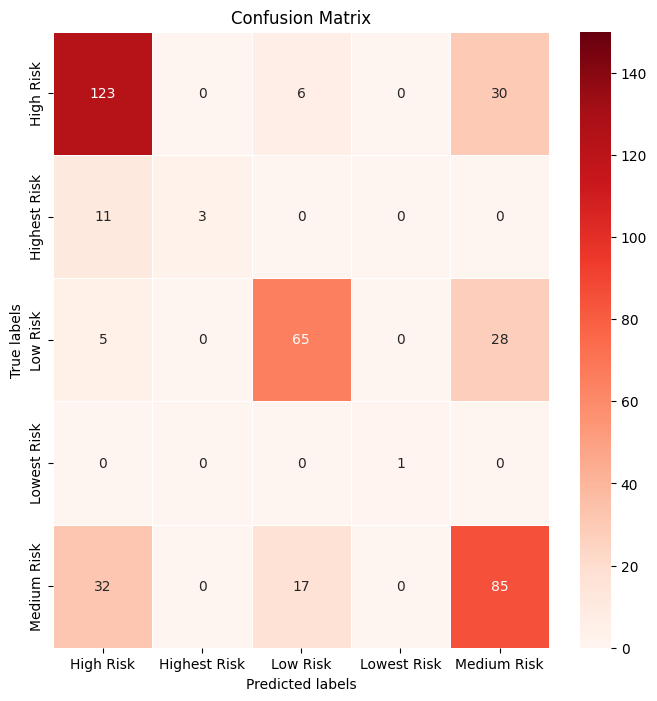

In [14]:
# Create a confusion matrix and display it with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm_df, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [15]:
from pycaret.classification import *

In [ ]:
from pycaret.classification import setup

#Pycaret deals wth categorcal values, so we don't need to encode the daata
clf1 = setup(data = X_train, target = y_train)

,Description,Value
0,Session id,8804
1,Target,Rating_id_encoded
2,Target type,Multiclass
3,Original data shape,"(1623, 28)"
4,Transformed data shape,"(1623, 39)"
5,Transformed train set shape,"(1136, 39)"
6,Transformed test set shape,"(487, 39)"
7,Numeric features,25
8,Categorical features,2
9,Preprocess,True


In [ ]:
# Comparing all models 
models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6849,0.3292,0.6849,0.6850,0.6776,0.5344,0.5380,0.6970
et,Extra Trees Classifier,0.6831,0.3377,0.6831,0.6866,0.6753,0.5341,0.5395,0.0820
rf,Random Forest Classifier,0.6725,0.3348,0.6725,0.6719,0.6624,0.5161,0.5212,0.1050
gbc,Gradient Boosting Classifier,0.6488,0.0000,0.6488,0.6747,0.6449,0.4905,0.5010,0.8010
lightgbm,Light Gradient Boosting Machine,0.6348,0.3237,0.6348,0.6665,0.6316,0.4735,0.4864,2.6000
dt,Decision Tree Classifier,0.6286,0.2943,0.6286,0.6449,0.6280,0.4593,0.4638,0.0220
lda,Linear Discriminant Analysis,0.5978,0.0000,0.5978,0.6401,0.6003,0.4235,0.4369,0.0230
ridge,Ridge Classifier,0.5908,0.0000,0.5908,0.5781,0.5567,0.3705,0.3847,0.0210
ada,Ada Boost Classifier,0.5221,0.0000,0.5221,0.4586,0.4568,0.2740,0.3304,0.0670
knn,K Neighbors Classifier,0.4736,0.2662,0.4736,0.4641,0.4599,0.2131,0.2163,0.3630


In [ ]:
# Picking the winner 
# optimize wth precision -> minimizing false positives
best_model = automl(optimize = 'Precision')

#Fine-tuning the best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7018,0.0000,0.7018,0.7016,0.6957,0.5640,0.5682
1,0.7105,0.0000,0.7105,0.7238,0.7031,0.5722,0.5746
2,0.7105,0.8451,0.7105,0.7008,0.6942,0.5722,0.5805
3,0.7018,0.8288,0.7018,0.7246,0.6928,0.5469,0.5561
4,0.6754,0.8177,0.6754,0.6687,0.6646,0.5262,0.5314
5,0.6491,0.8509,0.6491,0.6720,0.6348,0.4973,0.5163
6,0.7080,0.0000,0.7080,0.7162,0.7035,0.5617,0.5626
7,0.7080,0.0000,0.7080,0.7022,0.6991,0.5596,0.5636
8,0.6991,0.0000,0.6991,0.7028,0.6973,0.5555,0.5573


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [28]:
predictions = predict_model(best_model, data = X_test)
print(classification_report(y_test, predictions['prediction_label']))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       159
           1       0.36      0.29      0.32        14
           2       0.69      0.81      0.75        98
           3       0.00      0.00      0.00         1
           4       0.65      0.60      0.63       134

    accuracy                           0.69       406
   macro avg       0.49      0.49      0.49       406
weighted avg       0.69      0.69      0.69       406



In [29]:
predictions_tuned = predict_model(tuned_best_model, data = X_test)
print(classification_report(y_test, predictions_tuned['prediction_label']))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       159
           1       0.36      0.29      0.32        14
           2       0.69      0.81      0.75        98
           3       0.00      0.00      0.00         1
           4       0.65      0.60      0.63       134

    accuracy                           0.69       406
   macro avg       0.49      0.49      0.49       406
weighted avg       0.69      0.69      0.69       406



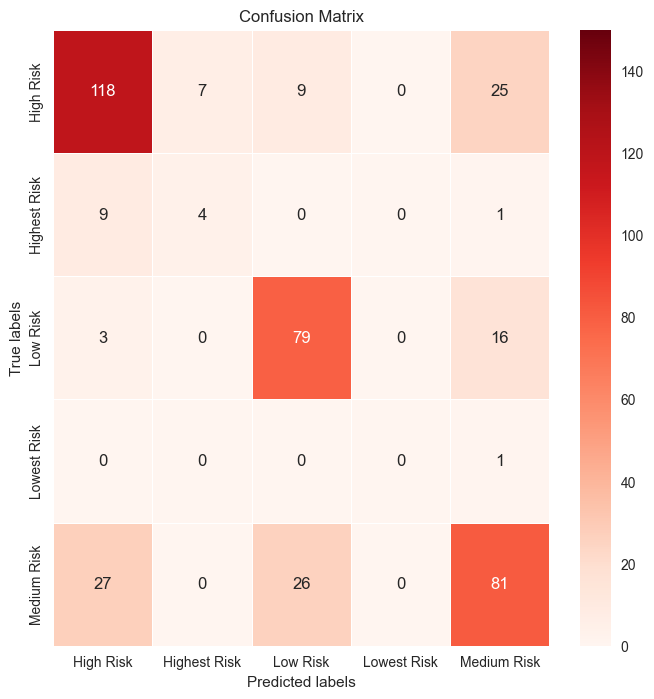

In [30]:
# Create a confusion matrix and display it with seaborn heatmap
cm = confusion_matrix(y_test, predictions_tuned['prediction_label'])
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm_df, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

XgBoost and Random Forest are the best models for ths dataset and it was the ones already used. But pycaret is good for a sanity check in case the data changes.